<a href="https://colab.research.google.com/github/hjjimmykim/prospectiveporpoise/blob/master/PolicyGradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload
%autoreload 2

# Standard
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import sympy as sp
from scipy.optimize import fsolve

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

    100% |████████████████████████████████| 91.1MB 123.5MB/s 
    100% |████████████████████████████████| 2.0MB 11.3MB/s 
fastai 1.0.42 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
Operation cancelled by user


In [0]:

# RL

gamma1 = 0# Decay rate
alpha1 = 0.1 # Learning rate
beta1 = 0.5   # Exploitation rate
gamma2 = 0 # Decay rate
alpha2 = 0.1 # Learning rate
beta2 = 0.5 # Exploitation rate


# Simulation
n_batch = 100 # Batch size
n_eps = 3       # Training episodes
n_steps = 10000 # Training steps
n_turns = 10000       # Turns in the test game
n_rec = n_steps/10       # For printing purposes

#Prosocial - delta is the magnitude of prosociality 1 = Prosocial 0 = Selfish
delta1 = 0.0
delta2 = 0.0

#Policy Gradient (REINFORCE)
num_agents = 2
smoothing_const = 0.7

t_change = 0
count = 10

In [0]:
def initialize():
  # Reward matrix (0 = left, 1 = right)
  # 1st coord. = Agent receiving the reward
  
  # 2nd coord. = State
  # 3rd coord. = Agent 1 action
  # 4th coord. = Agent 2 action

  RM = np.zeros([2,2,2,2])

  #Stag Hunt
  #0 = Hunt
  #1 = Forage
  
  RM[0][0][0][0] = 2
  RM[0][0][0][1] = -0.0
  RM[0][0][1][0] = 1
  RM[0][0][1][1] = 1
  RM[0][1][0][0] = 0
  RM[0][1][0][1] = 0
  RM[0][1][1][0] = 0
  RM[0][1][1][1] = 0

  RM[1][0][0][0] = 2
  RM[1][0][0][1] = 1
  RM[1][0][1][0] = -0.0
  RM[1][0][1][1] = 1
  RM[1][1][0][0] = 0
  RM[1][1][0][1] = 0
  RM[1][1][1][0] = 0
  RM[1][1][1][1] = 0
  
  # Transition probabilities
  # 1st coord. = State
  # 2nd coord. = Agent 1 action
  # 3rd coord. = Agent 2 action
  T = np.zeros([2,2,2])

  
  # One-state
  T[0][0][0] = 0
  T[0][0][1] = 0
  T[0][1][0] = 0
  T[0][1][1] = 0

  T[1][0][0] = 0
  T[1][0][1] = 0
  T[1][1][0] = 0
  T[1][1][1] = 0

  # Q-value
  # 1st coord. = Agent id
  # 2nd coord. = State
  # 3rd coord. = Action
  Q = np.zeros([2,2,2])

  # Initial condition
  Q[0][0][0] = 1/beta1 * np.log(0.3)
  Q[0][0][1] = 1/beta1 * np.log(0.7)
  Q[0][1][0] = 1/beta1 * np.log(0.4)
  Q[0][1][1] = 1/beta1 * np.log(0.6)

  Q[1][0][0] = 1/beta2 * np.log(0.7)
  Q[1][0][1] = 1/beta2 * np.log(0.3)
  Q[1][1][0] = 1/beta2 * np.log(0.7)
  Q[1][1][1] = 1/beta2 * np.log(0.3)
 
  return RM, T, Q

def softmax(Q,beta1,beta2):
  X = np.reshape(Q,[4,2]) # Row = agent & state pair; col = action
  X_beta = X * np.array([[beta1,beta1,beta2,beta2]]).transpose() # Betas should multiply by agents
  
  X1 = np.exp(X_beta[:,0])/np.sum(np.exp(X_beta),1)
  X2 = np.exp(X_beta[:,1])/np.sum(np.exp(X_beta),1)
  
  X = np.vstack([X1,X2])
  
  return np.reshape(X.transpose(),[2,2,2])

# For RM
def det_avg(F, X, T, i, s, a):
  # Calculate deterministic average over next states s' given current state s & your (i.e. agent i) action a
  # Must average over other agent's actions a_j
  
  # F = quantity to be averaged over
  # We need F(a_j) for all other agent actions a_j
  # X = behavior profile of the other agent j.
  # We need X(j,s,a_j) for all possible actions a_j
  # T = transition matrix
  # We need T(s,a,a_j,s') for all actions a_j and next states s'
  
  j = int(not(i)) # The other agent
  
  # Term 1: a_j=0 and next state=1
  # Term 2: a_j=0 and next state=0
  # Term 3: a_j=1 and next state=0
  # Term 4: a_j=1 and next state=1
  
  if s == 0:
      return X[0] * T[0] * F[0] \
      + X[0] * (1 - T[0]) * F[0] \
      + X[1] * T[1] * F[1] \
      + X[1] * (1 - T[1]) * F[1]
  elif s == 1:
      return X[0] * (1 - T[0]) * F[0] \
      + X[0] * T[0] * F[0] \
      + X[1] * (1 - T[1]) * F[1] \
      + X[1] * T[1] * F[1]

# For max Q
def det_avg2(F, X, T, i, s, a):
  # Calculate deterministic average over next states s' given current state s & your (i.e. agent i) action a
  # Must average over other agent's actions a_j
  
  # F = quantity to be averaged over
  # We need F(s') for all next states s'
  # X = behavior profile of the other agent j.
  # We need X(j,s,a_j) for all possible actions a_j
  # T = transition matrix
  # We need T(s,a,a_j,s') for all actions a_j and next states s'
  
  j = int(not(i)) # The other agent
  
  # Term 1: a_j=0 and next state=1
  # Term 2: a_j=0 and next state=0
  # Term 3: a_j=1 and next state=0
  # Term 4: a_j=1 and next state=1
  
  if s == 0:
      return X[0] * T[0] * F[1] \
      + X[0] * (1 - T[0]) * F[0] \
      + X[1] * T[1] * F[1] \
      + X[1] * (1 - T[1]) * F[0]
  elif s == 1:
      return X[0] * (1 - T[0]) * F[1] \
      + X[0] * T[0] * F[0] \
      + X[1] * (1 - T[1]) * F[1] \
      + X[1] * T[1] * F[0]
  
RM, T, Q = initialize()

In [0]:
def Q_learning(n_steps,beta1,beta2,RM,T,Q):
  
  t_start = time.time()
  t1 = time.time()

  # TD storage
  TD1 = np.zeros([2,2])
  TD2 = np.zeros([2,2])

  # Initial state
  s = 0

  #Initial V
  # coords = agent id, state
  V = np.zeros([2,2])

  # Save p1_s and p2_s trajectory
  p1_1 = []
  p1_2 = []
  p2_1 = []
  p2_2 = []
  t1_list = []
  t2_list = []

  # Save reward
  r1_list = []
  r2_list = []
  r_total_1 = 0
  r_total_2 = 0

  for i_ep in range(n_steps):
    # Behavior profile
      X = softmax(Q,beta1,beta2)

      # Action selection
      #p1 = np.exp(beta1*Q[0][s][0])/np.sum(np.exp(beta1*Q[0][s]))
      p1 = X[0][s][0]
      if p1 > np.random.random():
        a1 = 0
      else:
        a1 = 1

      #p2 = np.exp(beta2*Q[1][s][0])/np.sum(np.exp(beta2*Q[1][s]))
      p2 = X[1][s][0]
      if p2 > np.random.random():
        a2 = 0
      else:
        a2 = 1

      # Save p1_s & p2_s trajectory
      if s == 0:
        p1_1.append(p1)
        p2_1.append(p2)
        t1_list.append(i_ep)
      else:
        p1_2.append(p1)
        p2_2.append(p2)
        t2_list.append(i_ep)

      # Rewards
      r1 = (1-delta1)*RM[0][s][a1,a2] + delta1*RM[1][s][a1,a2]
      r2 = (1-delta2)*RM[1][s][a1,a2] + delta2*RM[0][s][a1,a2]

      r_total_1 += r1
      r_total_2 += r2

      # Save them


      # State transition
      s_old = s # Keep track of this for learning
      if T[s][a1][a2] > np.random.random():

        s = int(not(s))



      # TD learning --------------------------------------------------------------

      TD1[s_old][a1] += (1-gamma1) * r1 + gamma1 * np.max(Q[0][s]) - Q[0][s_old][a1]
      TD2[s_old][a2] += (1-gamma2) * r2 + gamma2 * np.max(Q[1][s]) - Q[1][s_old][a2] # Q-learning

      # Q-value and V update 
      if (i_ep+1) % n_batch == 0:

          Q[0] = Q[0] + alpha1*TD1/n_batch
          Q[1] = Q[1] + alpha2*TD2/n_batch

          TD1 = np.zeros([2,2])
          TD2 = np.zeros([2,2])

          r_list_1 = r_total_1/n_batch
          r_list_2 = r_total_2/n_batch

          r1_list.append(r_list_1)
          r2_list.append(r_list_2)

          r_total_1 = 0
          r_total_2 = 0 
          
          if i_ep % n_rec == 0 and i_ep != 0: 
          # Time stuff
            t2 = time.time()
            print('-----------------------------')
            print('Episode ' + str(i_ep))
            print('Runtime for episodes ' + str(i_ep - n_rec) + '-' + str(i_ep) + ': ' + str(t2-t1) + ' s')
            t1 = t2

            print('-----------------------------')
          
  return p1_1,p2_1,r1_list,r2_list


In [0]:
RM, T, Q = initialize()

p1_1,p2_1,r1_list,r2_list = Q_learning(n_steps,beta1,beta2,RM,T,Q)


Text(0, 0.5, 'Reward')

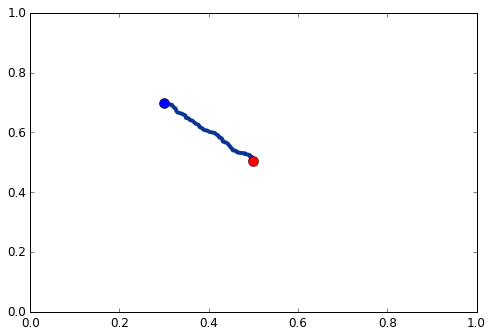

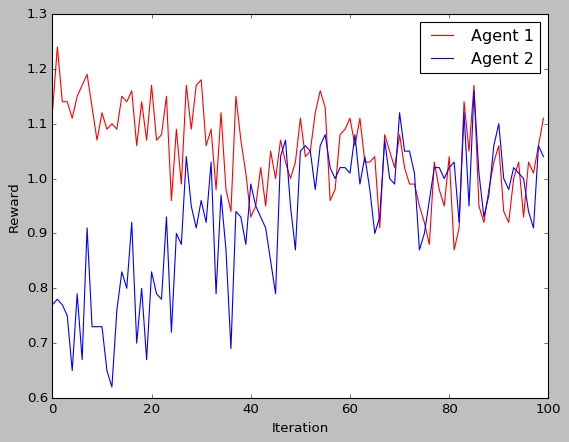

In [0]:
orange = '#ff8c13'
blue = '#0d3692'

plt.figure(facecolor = 'white')
plt.style.use('classic')
#plt.axis('square')

plt.plot(p1_1,p2_1,blue,linewidth=4)
plt.plot(p1_1[0],p2_1[0],'bo',markersize=10) # Initial
plt.plot(p1_1[-1],p2_1[-1],'ro',markersize=10) # Final


plt.xlim(0,1)
plt.ylim(0,1)

# Reward plot ------------------------------------------------------------------

plt.figure()
plt.plot(r1_list,"r-", label = 'Agent 1')
plt.plot(r2_list,"b-", label = 'Agent 2')
plt.legend(loc = 'upper right')
plt.xlabel('Iteration')
plt.ylabel('Reward')

In [0]:
#PyTorch
import torch

# Optimizer
import torch
from torch import autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

learning_rate = 0.1


class Policy(nn.Module):
  def __init__(self, input_dim = 1, output_dim = 1):
      super(Policy, self).__init__()

      self.input_dim = input_dim
      self.output_dim = output_dim

      self.ff = nn.Linear(1, 1, bias=True)

      # Episode policy and reward history 
      self.policy_history = Variable(torch.Tensor()) 
      self.reward_episode = []
      # Overall reward and loss history
      self.reward_history = []
      self.loss_history = []

  def forward(self, x):    
      model = nn.Sequential(self.ff,nn.Sigmoid())
      #model = self.ff(x)
      #r = nn.ReLU(model, inplace=False)
      
      return model(x)
    
def softmax(x,beta):
  X = x.clone()
  X_beta = X * beta # Betas should multiply by agents
  
  X1 = torch.exp(X_beta[0])/torch.sum(torch.exp(X_beta))
  X2 = torch.exp(X_beta[1])/torch.sum(torch.exp(X_beta))
  
  
  return X1,X2

  
def REINFORCE(p,r,b):
  rl = -torch.log(p) * (r-b)
  
  return rl

  

In [0]:
#PyTorch
import torch

# Optimizer
import torch
from torch import autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim


#dims
input_dim = 1
output_dim = 1

#State
s = 0

#Initial actions
a1 = torch.zeros(input_dim, requires_grad=True)
a2 = torch.zeros(input_dim, requires_grad=True)

# Save p1_s and p2_s trajectory
p1_1 = []
p2_1 = []

# Save reward
r1 = torch.zeros(input_dim, requires_grad=True)
r2 = torch.zeros(input_dim, requires_grad=True)
r1_list = []
r2_list = []
r_total = torch.zeros([num_agents,input_dim], requires_grad=True)
r_mean = torch.zeros([num_agents,input_dim], requires_grad=True)


# Initialize agents
Agents = []
for i in range(num_agents):
    Agents.append(Policy())

#Initialize baselines
baselines = [0 for _ in range(num_agents+1)]

# Initialize loss
losses = []
for i in range(num_agents):
    losses.append(torch.zeros([],requires_grad=True))

for j in range(n_steps):   

  # Action selection
  p1 = Agents[0](r1)
  p2 = Agents[1](r2)

  if p1[0] > np.random.random():
    a1 = 0
  else:
    a1 = 1

  if p2[0] > np.random.random():
    a2 = 0
  else:
    a2 = 1

  # Save p1_s & p2_s trajectory
  p1_1.append(p1[0])
  p2_1.append(p2[0])


  # Rewards
  for i in range(output_dim):
    r1[i] = (1-delta)*RM[0][s][a1,a2] + delta*RM[1][s][a1,a2]
    r2[i] = (1-delta)*RM[1][s][a1,a2] + delta*RM[0][s][a1,a2]


  r_total[0] = r_total[0] + r1
  r_total[1] = r_total[1] + r2

  r1_list.append(r1)
  r2_list.append(r2)

  #REINFORCE
  rl1 = REINFORCE(p1[0],r1,baselines[0])
  rl2 = REINFORCE(p2[0],r2,baselines[1])

  # Accumulate reward loss
  losses[0] = losses[0] + rl1
  losses[1] = losses[1] + rl2



  # Initialize optimizers for learning
  optimizers = []
  for i in range(num_agents):
      optimizers.append(optim.Adam(Agents[i].parameters()))

  for i in range(num_agents):
    # optimize
    optimizers[i].zero_grad()
    losses[i].backward()
    optimizers[i].step()

    r_mean[i] = r_total[i]/output_dim # Overall episode batch-averaged reward

    # Update baseline with batch-averaged reward
    baselines[i] = smoothing_const * baselines[i] + (1-smoothing_const)*r_mean
  
  

RuntimeError: ignored

Text(0, 0.5, 'Reward')

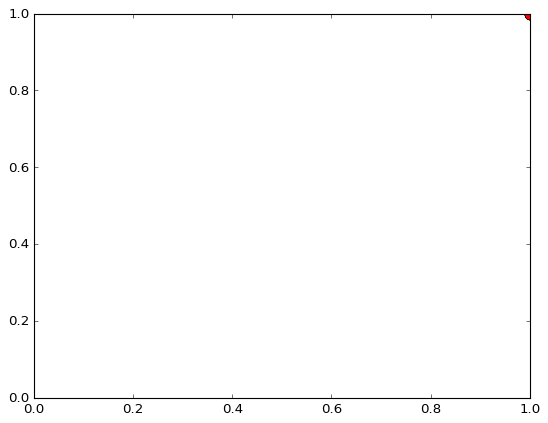

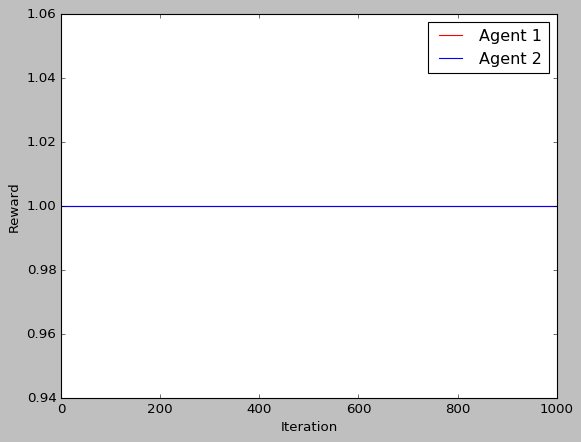

In [0]:
orange = '#ff8c13'
blue = '#0d3692'

plt.figure(facecolor = 'white')
plt.style.use('classic')
#plt.axis('square')

plt.plot(p1_1,p2_1,blue,linewidth=4)
plt.plot(p1_1[0],p2_1[0],'bo',markersize=10) # Initial
plt.plot(p1_1[-1],p2_1[-1],'ro',markersize=10) # Final


plt.xlim(0,1)
plt.ylim(0,1)

# Reward plot ------------------------------------------------------------------

plt.figure()
plt.plot(r1_list,"r-", label = 'Agent 1')
plt.plot(r2_list,"b-", label = 'Agent 2')
plt.legend(loc = 'upper right')
plt.xlabel('Iteration')
plt.ylabel('Reward')


tensor([0.0347], grad_fn=<ThMulBackward>)
tensor([0.0347], grad_fn=<ThMulBackward>)


[tensor([0.6000]), tensor([0.6000]), 0]